In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('default')

### Data Sourcing

In [34]:
#Downloading the data from the below file

dataset=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Exploratary_Data_Analysis/LendingCaseStudy/loan.csv')

### Data Cleaning

In [35]:
dataset.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [36]:
# Removing Columns which has null values in the all records.

dataset.dropna(axis=1, how='all', inplace=True)

In [37]:
# Removing Columns which has more than 25% data is null values
all_columns_percent_nullvalues=round(dataset.isna().sum()/ len(dataset) * 100,2);
filtered_columns=all_columns_percent_nullvalues[all_columns_percent_nullvalues>25]
dataset.drop(filtered_columns.index,inplace=True,axis=1);

In [38]:
# Removing Columns which may not useful for further analysis.
dataset.nunique()
# member_id                                 - It has unique values like id
# url                                       - It is a column to find the source of the file related to that loan .It won't help us for analysis .
# emp_title                                 - Again it is user-defined . It may change one to another borrower . It may not useuful for analysis .
# next_pymnt_d,last_credit_pull_d,
# last_pymnt_d,earliest_cr_line,
# last_pymnt_amnt,total_rec_prncp,
# total_rec_int,total_rec_late_fee,
# recoveries,collection_recovery_fee        - These columns won't help us for analysis . The reason is moreover it related to particular event also it will change person to person.
# title                                     - Again it is the user-defined values . It won't impact the analysis.
# acc_now_delinq,pymnt_plan,
# initial_list_status,
# collections_12_mths_ex_med,
# policy_code,application_type,
# acc_now_delinq,
# chargeoff_within_12_mths
# delinq_amnt
# tax_liens                                 - These columns having single value . So we can remove it .
# out_prncp,out_prncp_inv                   - It will keep changing month to month . So it doesn't help us to analyse.
# 'collections_12_mths_ex_med','tax_liens'  - These columns having only NAN and 0 values so we can remove it .
dataset.drop(['member_id','emp_title','url','last_credit_pull_d','title','acc_now_delinq','earliest_cr_line','last_pymnt_d', 'last_pymnt_amnt','policy_code','delinq_amnt','application_type','out_prncp', 'out_prncp_inv','chargeoff_within_12_mths','initial_list_status','pymnt_plan','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','collections_12_mths_ex_med','tax_liens'], axis = 1, inplace = True)


In [39]:
# Here we can remove the records which is having null values from the dataset . So that it doesn't impact the overall analysis.
dataset.dropna(inplace=True)

In [40]:
# Removing '%' in the int_rate,rev_utils

dataset['int_rate']=dataset['int_rate'].apply(lambda x:x.rstrip('%')).astype(float)
dataset['revol_util']=dataset['revol_util'].apply(lambda x:x.rstrip('%')).astype(float)

In [41]:
# Removing Extra White Space in the Column

dataset['term']=dataset['term'].apply(lambda x:x.strip())

In [42]:
# Here we want to analyze the Charged-Off driver variables so we can ignore the rows which are the current loan_payment_status
dataset=dataset[dataset['loan_status']!='Current']

### Adding Derived Variables

In [43]:
# Adding derived related to issue_d

dataset['issue_d'] = pd.to_datetime(dataset.issue_d, format='%b-%y')
dataset['issue_d']=dataset['issue_d'].apply(lambda x: x-pd.DateOffset(years=100) if x.year > 2020 else x)
dataset['issue_d_year'] = dataset.issue_d.dt.year
dataset['issue_d_month'] = dataset.issue_d.dt.strftime('%b')
dataset['issue_d_weekday'] = dataset.issue_d.dt.weekday
dataset['issue_d_year'] = dataset['issue_d_year'].astype(object)
dataset['issue_d_weekday'] = dataset['issue_d_weekday'].astype(object)

In [44]:
# Adding few derived columns for Bivariant analysis

dataset['loan_amnt_segms'] = pd.cut(dataset['loan_amnt'], [0, 7000, 14000, 21000, 28000, 35000], labels=['0-7000', '7000-14000', '14000-21000', '21000-28000', '28000 +'])

dataset['annual_inc_segms'] = pd.cut(dataset['annual_inc'], [0, 20000, 40000, 60000, 80000,1000000], labels=['0-20000', '20000-40000', '40000-60000', '60000-80000', '80000 +'])

dataset['installment_segms'] = pd.cut(dataset['installment'], [0, 250, 500, 750, 1000 ,1400], labels=['0-250', '250-500', '500-750', '750-1000','1000 +'])

dataset['int_rate_segms'] = pd.cut(dataset['int_rate'], [0, 10, 12.5, 16, 20], labels=['0-10', '10-13', '12.5-16', '16 +'])

dataset['dti_cats'] = pd.cut(dataset['dti'], [0, 5, 10, 15, 20, 25], labels=['0-5', '05-10', '10-15', '15-20', '25+'])

In [45]:
# Adding loanamount ratio (funded_amnt*100/loan_amnt)

dataset['app_loan_amnt_ratio'] =round(dataset.funded_amnt_inv*100/dataset.loan_amnt,2)

In [46]:
dataset.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,...,pub_rec_bankruptcies,issue_d_year,issue_d_month,issue_d_weekday,loan_amnt_segms,annual_inc_segms,installment_segms,int_rate_segms,dti_cats,app_loan_amnt_ratio
0,1077501,5000,5000,4975.0,36 months,10.65,162.87,B,B2,10+ years,...,0.0,2011,Dec,3,0-7000,20000-40000,0-250,10-13,NaN,99.5
1,1077430,2500,2500,2500.0,60 months,15.27,59.83,C,C4,< 1 year,...,0.0,2011,Dec,3,0-7000,20000-40000,0-250,12.5-16,0-5,100.0
2,1077175,2400,2400,2400.0,36 months,15.96,84.33,C,C5,10+ years,...,0.0,2011,Dec,3,0-7000,0-20000,0-250,12.5-16,05-10,100.0
3,1076863,10000,10000,10000.0,36 months,13.49,339.31,C,C1,10+ years,...,0.0,2011,Dec,3,7000-14000,40000-60000,250-500,12.5-16,15-20,100.0
5,1075269,5000,5000,5000.0,36 months,7.90,156.46,A,A4,3 years,...,0.0,2011,Dec,3,0-7000,20000-40000,0-250,0-10,10-15,100.0


In [47]:
# convert the text in term to numbers for better readability
dataset['term']=dataset.term.str.extract('(\d+)')
dataset.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,...,pub_rec_bankruptcies,issue_d_year,issue_d_month,issue_d_weekday,loan_amnt_segms,annual_inc_segms,installment_segms,int_rate_segms,dti_cats,app_loan_amnt_ratio
0,1077501,5000,5000,4975.0,36,10.65,162.87,B,B2,10+ years,...,0.0,2011,Dec,3,0-7000,20000-40000,0-250,10-13,NaN,99.5
1,1077430,2500,2500,2500.0,60,15.27,59.83,C,C4,< 1 year,...,0.0,2011,Dec,3,0-7000,20000-40000,0-250,12.5-16,0-5,100.0
2,1077175,2400,2400,2400.0,36,15.96,84.33,C,C5,10+ years,...,0.0,2011,Dec,3,0-7000,0-20000,0-250,12.5-16,05-10,100.0
3,1076863,10000,10000,10000.0,36,13.49,339.31,C,C1,10+ years,...,0.0,2011,Dec,3,7000-14000,40000-60000,250-500,12.5-16,15-20,100.0
5,1075269,5000,5000,5000.0,36,7.90,156.46,A,A4,3 years,...,0.0,2011,Dec,3,0-7000,20000-40000,0-250,0-10,10-15,100.0


In [48]:
dataset.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'total_pymnt', 'total_pymnt_inv', 'pub_rec_bankruptcies',
       'issue_d_year', 'issue_d_month', 'issue_d_weekday', 'loan_amnt_segms',
       'annual_inc_segms', 'installment_segms', 'int_rate_segms', 'dti_cats',
       'app_loan_amnt_ratio'],
      dtype='object')

### Univariate Analysis

#### The Aim of performing the Univariate Analysis is to identify the different patterns, characteristics of the attributes in Loan dataset
Some of the key attributes identified for the analysis are listed as below:
1. Loan Amount
2. Interest Rate
3. Annual income
4. Loan Purpose
5. Loan Status
6. Home Ownership
7. Grades

In [49]:
dataset.describe()

,id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,pub_rec_bankruptcies,app_loan_amnt_ratio
count,3.680000e+04,36800.000000,36800.000000,36800.000000,36800.000000,36800.000000,3.680000e+04,36800.000000,36800.000000,36800.000000,36800.000000,36800.000000,36800.000000,36800.000000,36800.000000,36800.000000,36800.000000,36800.000000,36800.000000
mean,6.833798e+05,11149.540761,10880.794837,10439.055845,11.983745,324.906537,6.943448e+04,13.334529,0.146141,0.869755,9.302473,0.054185,13373.771658,48.992830,22.152120,12000.654704,11525.593084,0.041821,94.824049
std,2.014118e+05,7369.855703,7109.157574,7008.522880,3.701182,208.891979,6.402159e+04,6.650154,0.491844,1.068063,4.375839,0.235562,15848.564286,28.313209,11.407797,8854.568117,8710.301644,0.200859,15.016760
min,5.473400e+04,500.000000,500.000000,0.000000,5.420000,16.080000,4.000000e+03,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,5.172388e+05,5500.000000,5400.000000,5000.000000,8.940000,167.730000,4.113300e+04,8.220000,0.000000,0.000000,6.000000,0.000000,3728.750000,25.600000,14.000000,5572.034728,5274.417500,0.000000,98.410000
50%,6.600330e+05,10000.000000,9600.000000,9000.000000,11.830000,280.110000,6.000000e+04,13.430000,0.000000,1.000000,9.000000,0.000000,8867.500000,49.500000,20.000000,9815.269906,9357.340000,0.000000,99.970000
75%,8.310768e+05,15000.000000,15000.000000,14350.000000,14.460000,429.365000,8.300000e+04,18.590000,0.000000,1.000000,12.000000,0.000000,17028.000000,72.500000,29.000000,16303.695000,15619.730000,0.000000,100.000000
max,1.077501e+06,35000.000000,35000.000000,35000.000000,24.400000,1305.190000,6.000000e+06,29.990000,11.000000,8.000000,44.000000,4.000000,149588.000000,99.900000,90.000000,58563.679930,58563.680000,2.000000,100.000000


In [50]:
dataset.dtypes

id                               int64
loan_amnt                        int64
funded_amnt                      int64
funded_amnt_inv                float64
term                            object
int_rate                       float64
installment                    float64
grade                           object
sub_grade                       object
emp_length                      object
home_ownership                  object
annual_inc                     float64
verification_status             object
issue_d                 datetime64[ns]
loan_status                     object
purpose                         object
zip_code                        object
addr_state                      object
dti                            float64
delinq_2yrs                      int64
inq_last_6mths                   int64
open_acc                         int64
pub_rec                          int64
revol_bal                        int64
revol_util                     float64
total_acc                

count    36800.000000
mean     11149.540761
std       7369.855703
min        500.000000
25%       5500.000000
50%      10000.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64


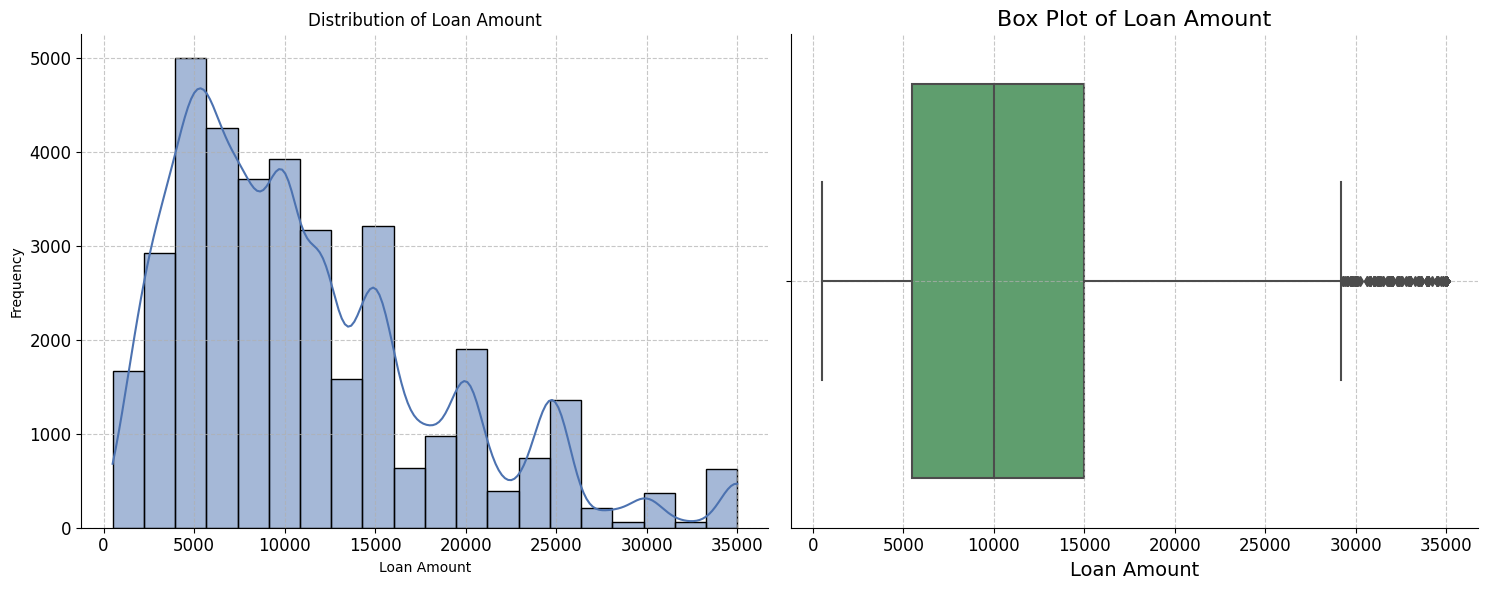

In [51]:
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 6))

# Calculate descriptive statistics
loan_stats = dataset['loan_amnt'].describe()

# Create a histogram on the left subplot (axis1)
sns.histplot(dataset['loan_amnt'], bins=20, kde=True, ax=axis1, color='#4c72b0', edgecolor='black')
axis1.set_title('Distribution of Loan Amount')
axis1.set_xlabel('Loan Amount')
axis1.set_ylabel('Frequency')
axis1.spines['top'].set_visible(False)
axis1.spines['right'].set_visible(False)
axis1.grid(True, linestyle='--', alpha=0.7)
axis1.tick_params(axis='both', which='major', labelsize=12)

# Create a box plot on the right subplot (axis2)
sns.boxplot(x=dataset['loan_amnt'], ax=axis2, color='#55a868')
axis2.set_title('Box Plot of Loan Amount', fontsize=16)
axis2.set_xlabel('Loan Amount', fontsize=14)
axis2.spines['top'].set_visible(False)
axis2.spines['right'].set_visible(False)
axis2.grid(True, linestyle='--', alpha=0.7)
axis2.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
print(loan_stats)
plt.show()

# Observation :

# As depicted in the graphs below, a substantial majority of individuals fall within the range of 'Loan Amount' between 5,500 and 15,000.

count    36800.000000
mean        11.983745
std          3.701182
min          5.420000
50%         11.830000
80%         15.230000
90%         16.820000
max         24.400000
Name: int_rate, dtype: float64


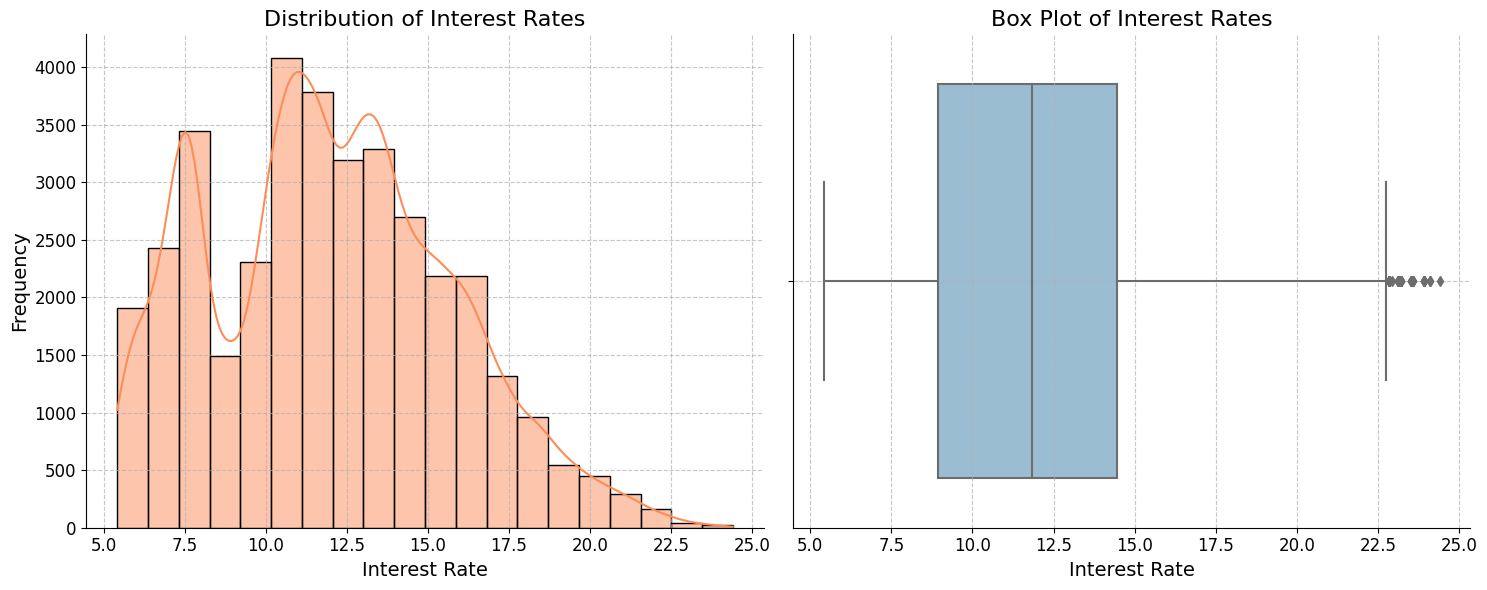

In [52]:
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 6))

interest_rate_stats =dataset['int_rate'].describe(percentiles=[0.8,0.9])

# Create a histogram on the left subplot (axis1)

sns.histplot(dataset['int_rate'], bins=20, kde=True, ax=axis1, color='#fc8d59', edgecolor='black')
axis1.set_title('Distribution of Interest Rates', fontsize=16)
axis1.set_xlabel('Interest Rate', fontsize=14)
axis1.set_ylabel('Frequency', fontsize=14)
axis1.spines['top'].set_visible(False)
axis1.spines['right'].set_visible(False)
axis1.grid(True, linestyle='--', alpha=0.7)
axis1.tick_params(axis='both', which='major', labelsize=12)

# Create a box plot on the right subplot (axis2)

sns.boxplot(x=dataset['int_rate'], ax=axis2, color='#91bfdb')
axis2.set_title('Box Plot of Interest Rates', fontsize=16)
axis2.set_xlabel('Interest Rate', fontsize=14)
axis2.spines['top'].set_visible(False)
axis2.spines['right'].set_visible(False)
axis2.grid(True, linestyle='--', alpha=0.7)
axis2.tick_params(axis='both', which='major', labelsize=12)
print(interest_rate_stats)
plt.tight_layout()
plt.show()

# Observation :

# The 'Interest rates' range from 10% to 14%; nevertheless, there are instances where the interest rates for loans can reach as high as 24%.

#### Observation :
#####  Maximum people who take loans are having the Income in range of 20000 - 40000

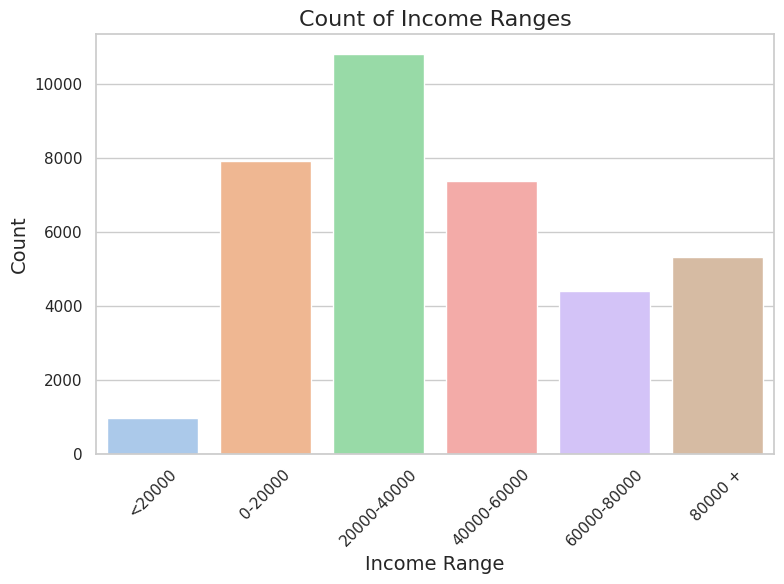

In [53]:
#create the range of income

income_ranges = pd.cut(dataset['annual_inc'], bins=[0, 20000, 40000, 60000, 80000, 100000, float('inf')], labels=['<20000', '0-20000', '20000-40000', '40000-60000', '60000-80000', '80000 +'])
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
sns.countplot(x=income_ranges, palette="pastel")

# Add title and labels
plt.title('Count of Income Ranges', fontsize=16)
plt.xlabel('Income Range', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)


plt.tight_layout()
plt.show()

# Observation :

# The majority of loan applicants have reported an income falling within the range of 20,000 to 40,000.

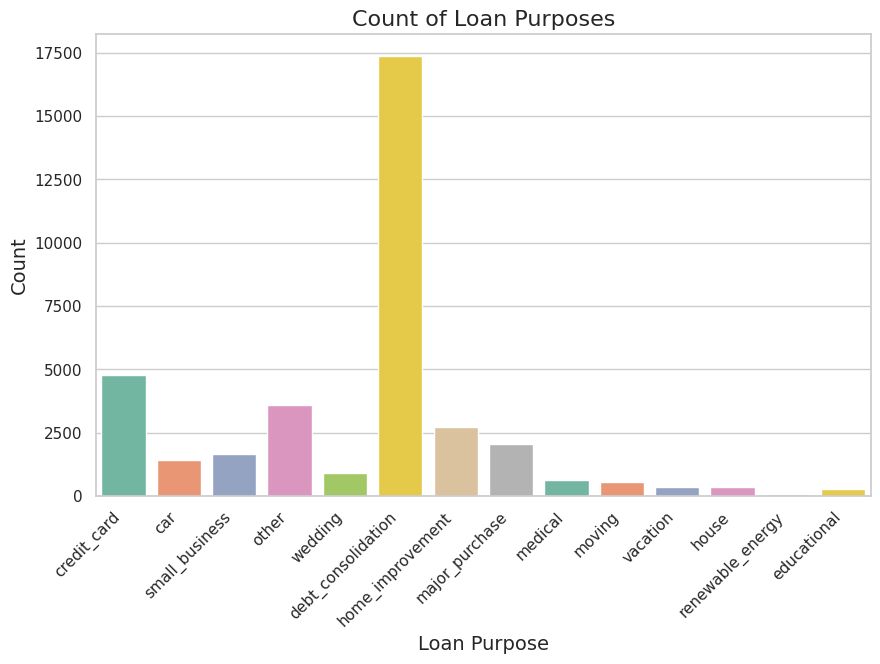

In [54]:
# Different purposes for which loan is dispersed

plt.figure(figsize=(10, 6))

sns.countplot(data=dataset, x='purpose', palette='Set2')  # Using the Set2 color palette

# Add title and labels
plt.title('Count of Loan Purposes', fontsize=16)
plt.xlabel('Loan Purpose', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.show()

# Observation:

# The primary purpose for obtaining loans is predominantly debt consolidation, followed closely by credit card debt repayment.

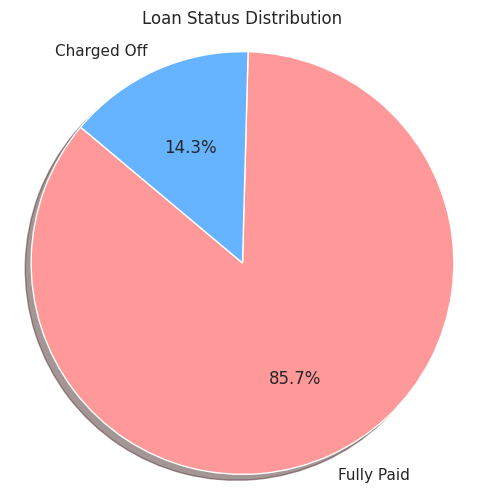

In [55]:
#Loan Status tells about the percentage of charged off vs fully paid loans

plt.figure(figsize=(6, 6))
loan_status_counts = dataset['loan_status'].value_counts()
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
plt.pie(loan_status_counts,
        labels=loan_status_counts.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
        shadow=True)
plt.title('Loan Status Distribution')
plt.axis('equal')
plt.show()

# Observation:

# It can be inferred that, out of a total of 50 loans, approximately 7 are projected to be charged off.


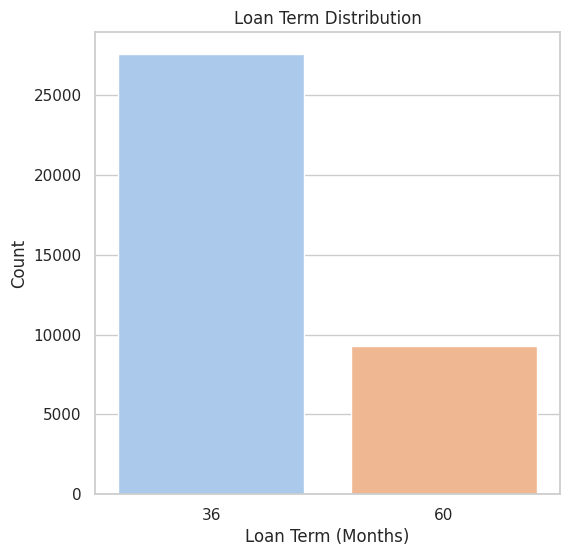

In [56]:
# Term Distribution

plt.figure(figsize=(6, 6))
sns.set(style="whitegrid", palette="pastel")  # Setting a white grid background and using a pastel color palette
sns.countplot(data=dataset, x='term', order=dataset['term'].value_counts().index)
plt.title('Loan Term Distribution')
plt.xlabel('Loan Term (Months)')
plt.ylabel('Count')
plt.show()

# Observation:

# The data clearly indicates that a higher proportion of borrowers exhibit a preference for shorter-term loans, opting for 30 months over 60 months.

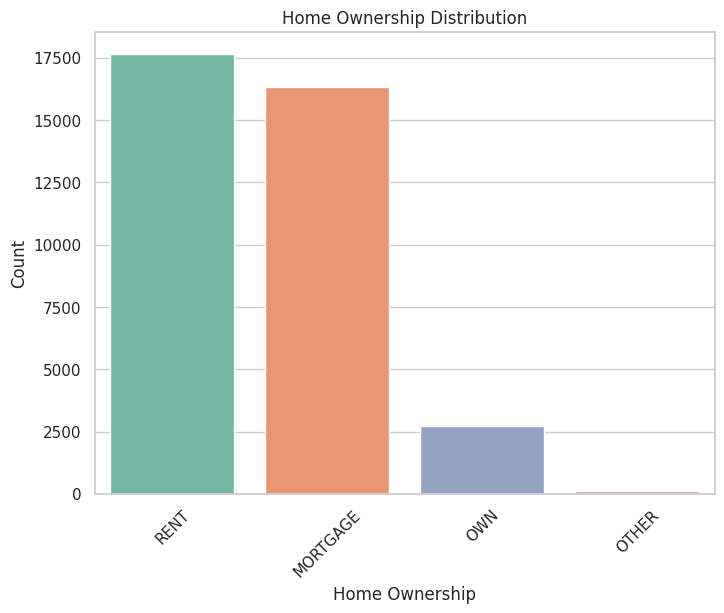

In [57]:
# Home Ownership distribution
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")  # Setting a white grid background
sns.countplot(data=dataset, x='home_ownership',
              order=dataset['home_ownership'].value_counts().index,
              palette='Set2')
plt.title('Home Ownership Distribution')
plt.xlabel('Home Ownership')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Observation :

# Individuals who are either renting or have a mortgage tend to take out loans more frequently compared to those who own their own houses.

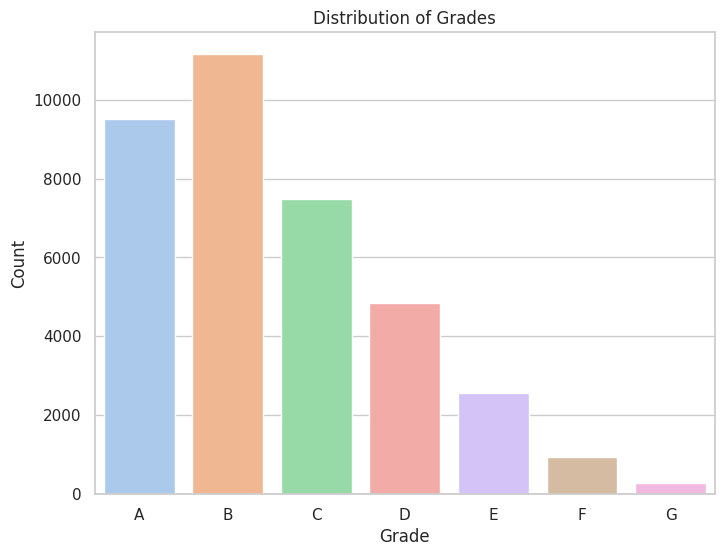

In [58]:
# Create a bar chart for grades

plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")  # Setting a white grid background
sns.countplot(data=dataset, x='grade',
              palette='pastel',
              order=sorted(dataset['grade'].unique()))
plt.title('Distribution of Grades')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.show()

# Observation:

# The B Grade category has demonstrated a higher propensity for loan acquisition compared to the other grade categories.

## Conclusion - Univariate Analysis



*   The applicants primarily seek loans in the range of 5,500 to 15,000, with the maximum loan amount requested being 35,000.

*   While the majority of applicants are charged interest rates ranging from 10% to 14%, there are instances where interest rates can go as high as 24%.

*   Among loan purposes, debt consolidation ranks highest, with over 17,000 applicants selecting it, followed by 'Credit card' which has slightly less than 5,000 applications.

*   Regarding loan status, approximately 85.7% of borrowers have successfully paid off their loans, while 14.3% have experienced a 'Charged off' status.

*   Loans with a term of "36" months are preferred by over 25,000 borrowers, whereas those with a term of "60" months are requested by fewer than 10,000 applicants.

*   The majority of borrowers indicate 'Rent' as their primary form of home ownership, followed closely by 'Mortgage'.





### Segmented Analysis

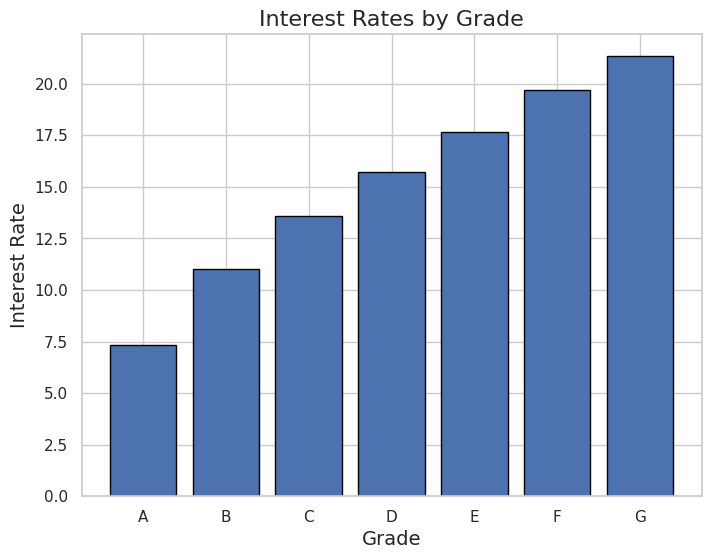

In [59]:
# Created a bar chart to visualize the mean interest rate by grade

grade_segments = dataset.groupby('grade')['int_rate'].mean().reset_index()
grades = grade_segments['grade']
int_rates = grade_segments['int_rate']
plt.figure(figsize=(8, 6))
plt.bar(grades, int_rates, edgecolor='black')
plt.title('Interest Rates by Grade', fontsize=16)
plt.xlabel('Grade', fontsize=14)
plt.ylabel('Interest Rate', fontsize=14)
plt.show()

# Observation :

#  it is evident that the mean 'Interest Rate' is highest for the 'G' grade, reaching nearly 24%. Conversely, for 'A' grade borrowers, the maximum 'Interest Rate' is below 7.5%.


### BiVariant Analysis

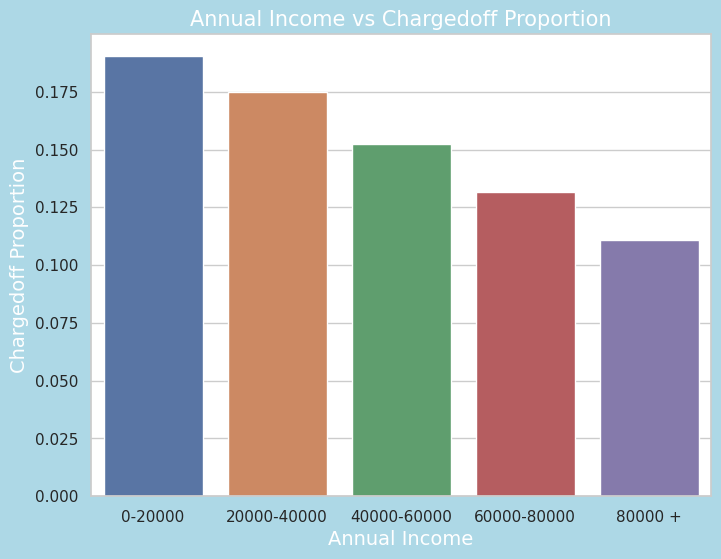

In [60]:
#Annual Income vs Chargedoff Proportion

income_range_vs_loan = dataset.groupby(['annual_inc_segms', 'loan_status']).loan_status.count().unstack().fillna(0).reset_index()
income_range_vs_loan['Total'] = income_range_vs_loan['Charged Off'] + income_range_vs_loan['Fully Paid']
income_range_vs_loan['Chargedoff_Proportion'] = income_range_vs_loan['Charged Off'] / income_range_vs_loan['Total']
income_range_vs_loan.sort_values('Chargedoff_Proportion', ascending=False)

fig, axis2 = plt.subplots(figsize=(8, 6),facecolor='lightblue')
axis2.set_title('Annual Income vs Chargedoff Proportion',fontsize=15,color = 'w')
axis2=sns.barplot(x='annual_inc_segms', y='Chargedoff_Proportion', data=income_range_vs_loan)
axis2.set_ylabel('Chargedoff Proportion',fontsize=14,color = 'w')
axis2.set_xlabel('Annual Income',fontsize=14,color='w')
plt.show()

# Observation :

# As annual income increases, the likelihood of experiencing a charge-off decreases.

## **Observation:**

When annual income increases , the chances of chargedoff getting decreases .

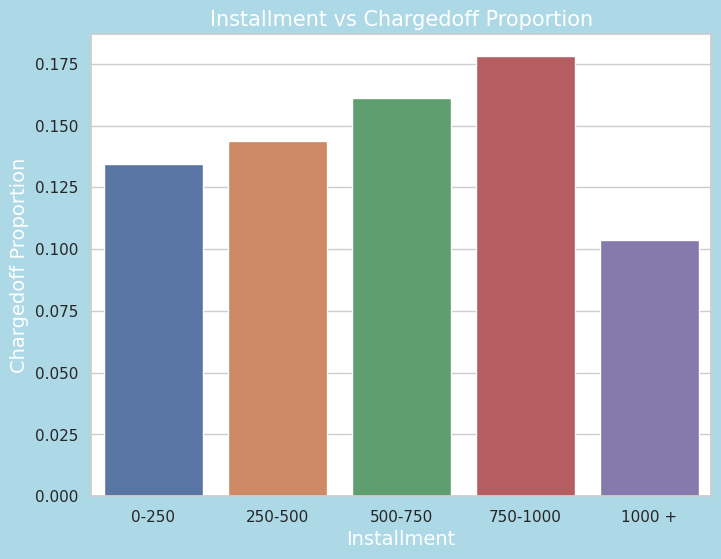

In [61]:
#Installment vs Chargedoff Proportion

installment_range_vs_loan = dataset.groupby(['installment_segms','loan_status']).loan_status.count().unstack().fillna(0).reset_index()
installment_range_vs_loan['Total'] = installment_range_vs_loan['Charged Off'] + installment_range_vs_loan['Fully Paid']
installment_range_vs_loan['Chargedoff_Proportion'] = installment_range_vs_loan['Charged Off'] / installment_range_vs_loan['Total']
installment_range_vs_loan.sort_values('Chargedoff_Proportion', ascending=False)

fig, axis1 = plt.subplots(figsize=(8, 6),facecolor='lightblue')
axis1.set_title('Installment vs Chargedoff Proportion',fontsize=15,color = 'w')
axis1=sns.barplot(x='installment_segms', y='Chargedoff_Proportion', data=installment_range_vs_loan)
axis1.set_ylabel('Chargedoff Proportion',fontsize=14,color = 'w')
axis1.set_xlabel('Installment',fontsize=14,color='w')
plt.show()

# Observation :

# Installment amounts exceeding 1000 are associated with a lower likelihood of experiencing a charge-off.

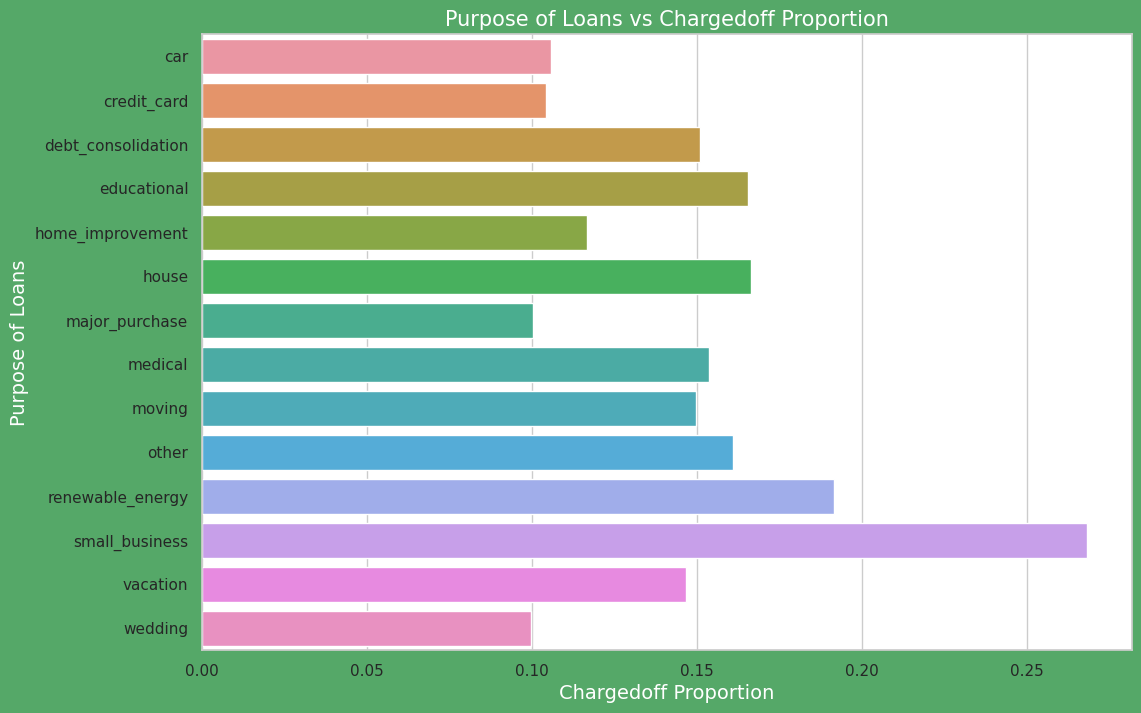

In [62]:
purpose_vs_loan = dataset.groupby(['purpose', 'loan_status']).loan_status.count().unstack().fillna(0).reset_index()
purpose_vs_loan['Total'] = purpose_vs_loan['Charged Off'] + purpose_vs_loan['Fully Paid']
purpose_vs_loan['Chargedoff_Proportion'] = purpose_vs_loan['Charged Off'] / purpose_vs_loan['Total']
purpose_vs_loan.sort_values('Chargedoff_Proportion', ascending=False)

fig, axis1 = plt.subplots(figsize=(12, 8),facecolor='g')
axis1.set_title('Purpose of Loans vs Chargedoff Proportion',fontsize=15,color = 'w')
axis1=sns.barplot(y='purpose', x='Chargedoff_Proportion', data=purpose_vs_loan)
axis1.set_ylabel('Purpose of Loans',fontsize=14,color='w')
axis1.set_xlabel('Chargedoff Proportion',fontsize=14,color = 'w')
plt.show()

# Observation :

# Loans designated for the purpose of "Small Business" are more likely to result in a charge-off.

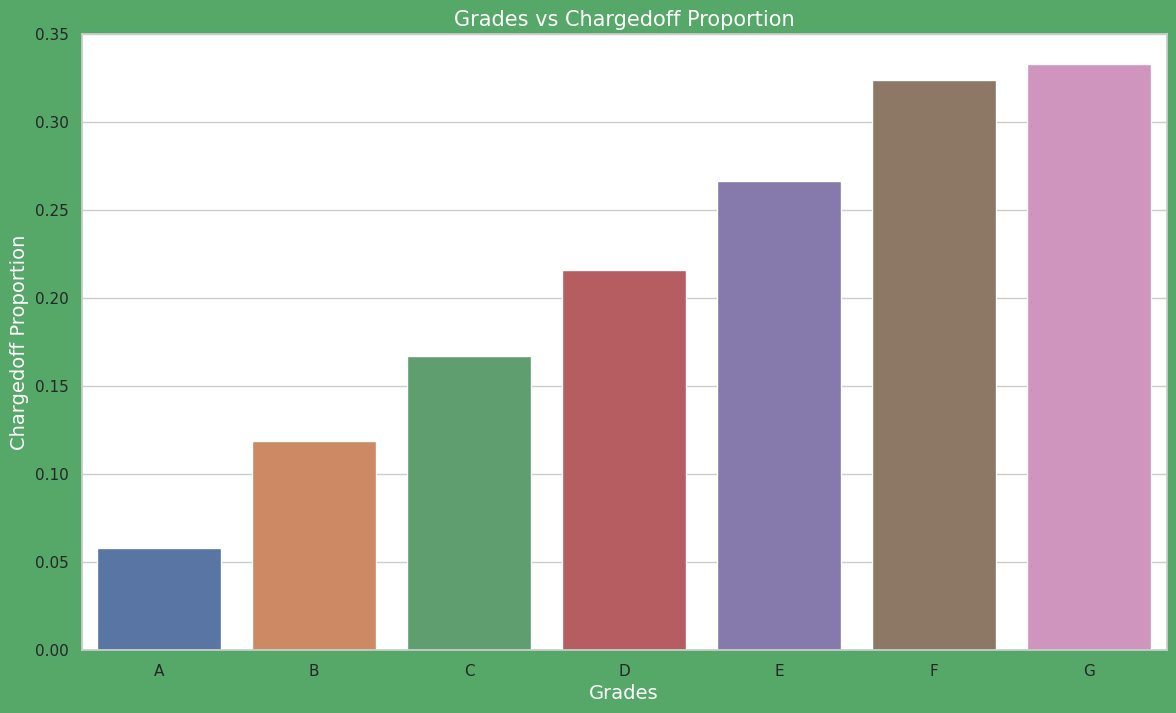

In [63]:
grade_vs_loan = dataset.groupby(['grade', 'loan_status']).loan_status.count().unstack().fillna(0).reset_index()
grade_vs_loan['Total'] = grade_vs_loan['Charged Off'] + grade_vs_loan['Fully Paid']
grade_vs_loan['Chargedoff_Proportion'] = grade_vs_loan['Charged Off'] / grade_vs_loan['Total']
grade_vs_loan.sort_values('Chargedoff_Proportion', ascending=False)

fig, axis1 = plt.subplots(figsize=(14, 8),facecolor='g')
axis1.set_title('Grades vs Chargedoff Proportion',fontsize=15,color='w')
axis1=sns.barplot(x='grade', y='Chargedoff_Proportion', data=grade_vs_loan)
axis1.set_xlabel('Grades',fontsize=14,color='w')
axis1.set_ylabel('Chargedoff Proportion',fontsize=14,color ='w')
plt.show()

# Observation :

# Indeed, the likelihood of a charge-off is significantly elevated for borrowers in G and F grades, while it is notably lower for those in the A grade.

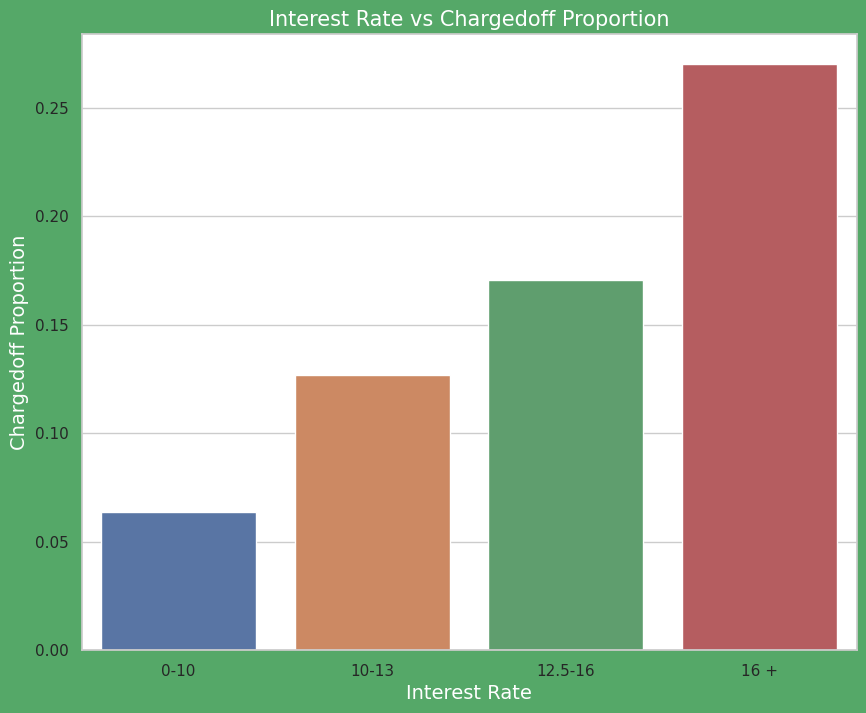

In [64]:
interest_vs_loan = dataset.groupby(['int_rate_segms', 'loan_status']).loan_status.count().unstack().fillna(0).reset_index()
interest_vs_loan['Total'] = interest_vs_loan['Charged Off'] + interest_vs_loan['Fully Paid']
interest_vs_loan['Chargedoff_Proportion'] = interest_vs_loan['Charged Off'] / interest_vs_loan['Total']
interest_vs_loan.sort_values('Chargedoff_Proportion', ascending=False)

fig, axis1 = plt.subplots(figsize=(10, 8),facecolor='g')
axis1.set_title('Interest Rate vs Chargedoff Proportion',fontsize=15,color='w')
axis1=sns.barplot(x='int_rate_segms', y='Chargedoff_Proportion', data=interest_vs_loan)
axis1.set_xlabel('Interest Rate',fontsize=14,color='w')
axis1.set_ylabel('Chargedoff Proportion',fontsize=14,color = 'w')
plt.show()

# Observation :

# As anticipated, an increase in the interest rate is strongly correlated with a higher likelihood of experiencing a charge-off.

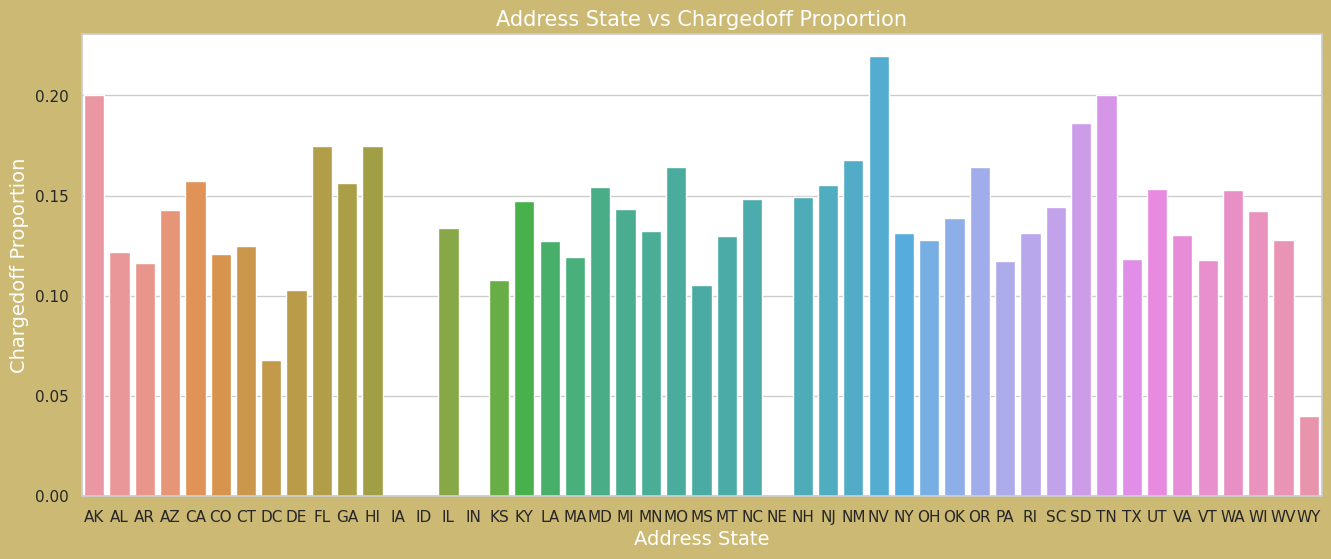

In [65]:
state_vs_loan = dataset.groupby(['addr_state', 'loan_status']).loan_status.count().unstack().fillna(0).reset_index()
state_vs_loan['Total'] = state_vs_loan['Charged Off'] + state_vs_loan['Fully Paid']
state_vs_loan['Chargedoff_Proportion'] = state_vs_loan['Charged Off'] / state_vs_loan['Total']
state_vs_loan.sort_values('Chargedoff_Proportion', ascending=False)

fig, axis1 = plt.subplots(figsize=(16, 6),facecolor='y')
axis1.set_title('Address State vs Chargedoff Proportion',fontsize=15,color='w')
axis1=sns.barplot(x='addr_state', y='Chargedoff_Proportion', data=state_vs_loan)
axis1.set_xlabel('Address State',fontsize=14,color='w')
axis1.set_ylabel('Chargedoff Proportion',fontsize=14,color = 'w')
plt.show()

# Observation:

# The states of NV, TN, and SD exhibit a notable number of charged-off cases in relation to the overall volume of applications.

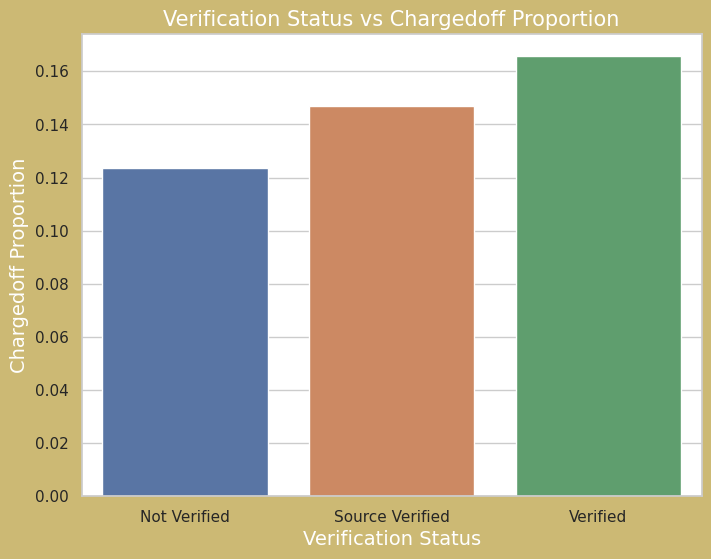

In [66]:
verfy_vs_loan = dataset.groupby(['verification_status', 'loan_status']).loan_status.count().unstack().fillna(0).reset_index()
verfy_vs_loan['Total'] = verfy_vs_loan['Charged Off'] + verfy_vs_loan['Fully Paid']
verfy_vs_loan['Chargedoff_Proportion'] = verfy_vs_loan['Charged Off'] / verfy_vs_loan['Total']
verfy_vs_loan.sort_values('Chargedoff_Proportion', ascending=False)

fig, axis1 = plt.subplots(figsize=(8, 6),facecolor='y')
axis1.set_title('Verification Status vs Chargedoff Proportion',fontsize=15,color='w')
axis1=sns.barplot(x='verification_status', y='Chargedoff_Proportion', data=verfy_vs_loan)
axis1.set_xlabel('Verification Status',fontsize=14,color='w')
axis1.set_ylabel('Chargedoff Proportion',fontsize=14,color = 'w')
plt.show()

# Observations :

# The available data doesn't provide a significant enough distinction to draw a conclusive decision.

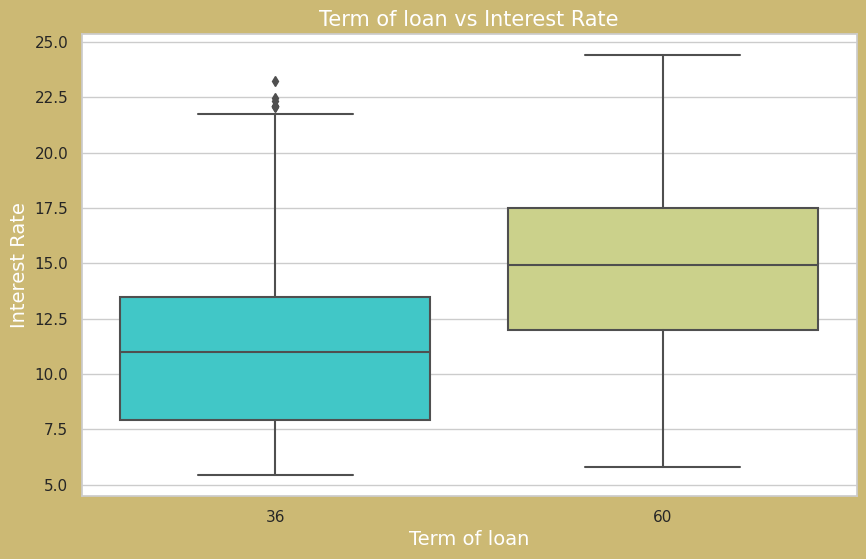

In [67]:
# Bivariate Analysis - Term of loan vs Interest Rate
# Box Plot

plt.figure(figsize=(10,6),facecolor='y')
axis = sns.boxplot(y='int_rate', x='term', data =dataset,palette='rainbow')
axis.set_title('Term of loan vs Interest Rate',fontsize=15,color='w')
axis.set_ylabel('Interest Rate',fontsize=14,color = 'w')
axis.set_xlabel('Term of loan',fontsize=14,color = 'w')
plt.show()

# Observation :

# The interest rates for loans with a 60-month duration are considerably higher compared to those with shorter terms.

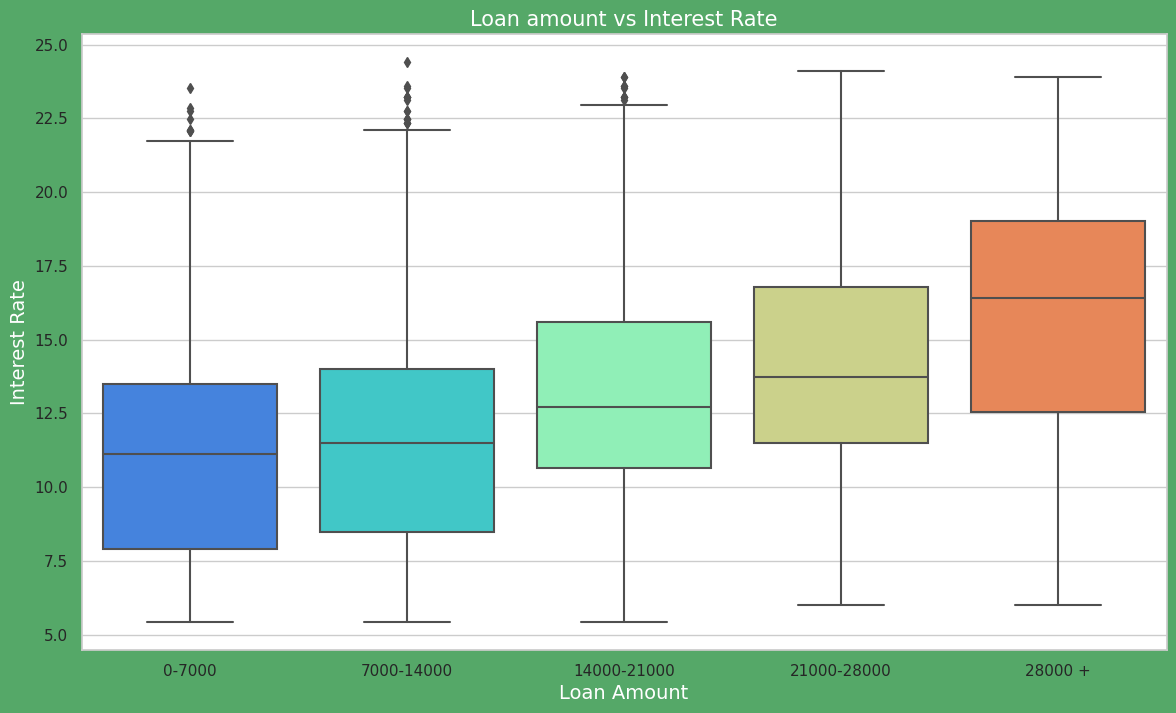

In [68]:
plt.figure(figsize=(14,8),facecolor='g')
axis = sns.boxplot(y='int_rate', x='loan_amnt_segms', data =dataset,palette='rainbow')
axis.set_title('Loan amount vs Interest Rate',fontsize=15,color='w')
axis.set_ylabel('Interest Rate',fontsize=14,color = 'w')
axis.set_xlabel('Loan Amount',fontsize=14,color = 'w')
plt.show()

# Observation :

# The interest rate demonstrates a positive coefficient with the loan amount. This means that as the loan amount increases, the interest rate also tends to rise.

# **Bivariate analysis conclusion :**



*   Borrowers in grades G and F are at higher risk of charge-offs, while those in grade A have a lower likelihood of charge-offs.

*   Loans exceeding 1000 demonstrate a lower likelihood of charge-offs.

*   'Small Business' loans are associated with a higher probability of charge-offs.

*   There is a positive correlation between interest rates and loan amounts, indicating that as loan amounts increase, interest rates tend to rise.

*   States like NV, TN, and SD exhibit a notable number of charged-offs relative to the total number of applications.

*   For loans with a 60-month duration, interest rates tend to be significantly higher compared to shorter-term loans.





